In [85]:
from skimage import io
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from circle_fit import taubinSVD, hyperSVD
import PIL
from PIL import ImageTk, Image, ImageDraw
from tkinter import *
from glob import glob
import glob
from skimage.draw import disk
import mahotas
from mahotas import features
import math
import tifffile as tif
from PIL import Image


def takeslice(thrdarray,x1,y1,x2,y2, layerindex):
    plt.imshow(thrdarray[:,layerindex,:,:])
    plt.scatter(x1,y1,c='c')
    plt.scatter(x2,y2, c='c')
    plt.show()
    slope=(y2-y1)/(x2-x1)
    indicies=[]
    for i in range(x2-x1):
        newx=i+x1
        newy=y1+int(slope*i)
        indicies.append((newy,newx))
    newimage=np.zeros((thrdarray.shape[1],(x2-x1),thrdarray.shape[3]))
    for i in range(thrdarray.shape[1]):
        layer=thrdarray[:,i,:,:]
        for j in range(x2-x1):
            newimage[i,j,:]=layer[indicies[j][0],indicies[j][1],:]
    hyp=int(((x2-x1)**2+(y2-y1)**2)**0.5)
    newimage_res = cv2.resize(newimage, dsize=(hyp, thrdarray.shape[1]), interpolation= cv2.INTER_LINEAR)
    plt.imshow(newimage_res)
    plt.show()
    return(newimage_res)

#ToDo- Generalize this component-
oct1 = io.imread(r"Q:\BOOM\EsophagealCancerStudy\Data_For_Processing\ID270\Normal\OCT\EsophagealCancerStudy_0001_Mode3D_ID270_ADJN.tiff")
print(oct1.shape)


(382, 1024, 1178, 4)


In [ ]:
#Reshape to account for changed proportions upon exporting-

#May need to recalculate these on sample to sample basis-
newshape=(712,236,450,3)
resizedoct=np.zeros(newshape)

for i in range(712):
    layer=oct1[i,:,:,:]
    layer2=cv2.resize(layer, (450,236), interpolation = cv2.INTER_LINEAR)
    resizedoct[i,:,:,:]=layer2

# newshape2=newshape=(712,236,450,3)
# resizedoct2=np.zeros(newshape2)
# for i in range(712):
#     layer=resizedoct[i,:,:,:]
#     layer2=cv2.resize(layer, (450,236), interpolation = cv2.INTER_LINEAR)
#     resizedoct2[i,:,:,:]=layer2

#Normalize
resizedoct=resizedoct/np.max(resizedoct)
#Okay that took like 4 secounds not sure what my prob is lol

0


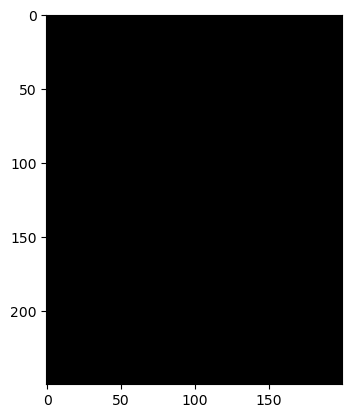

1


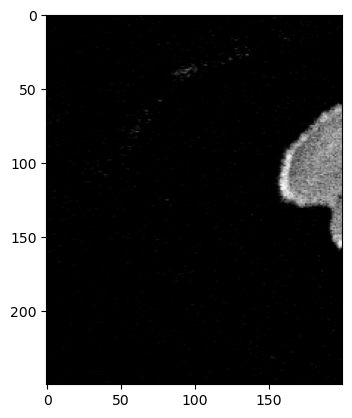

2


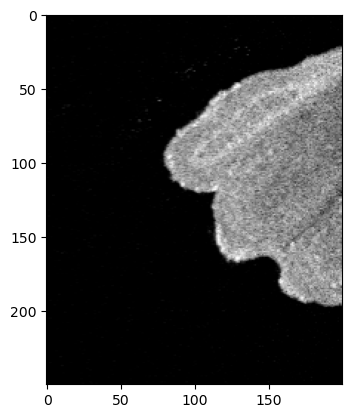

3


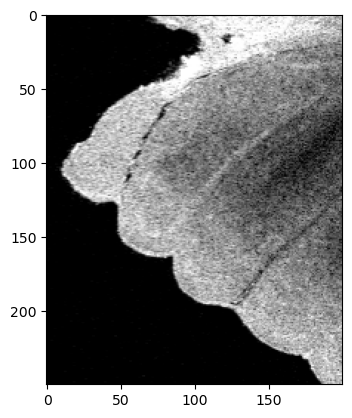

4


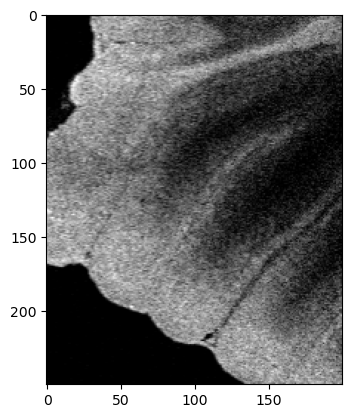

5


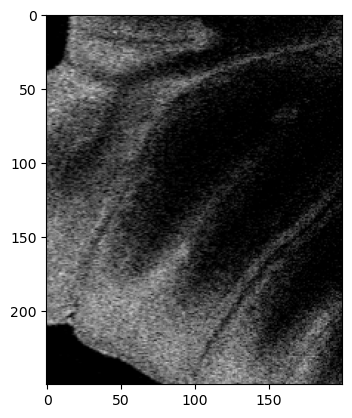

6


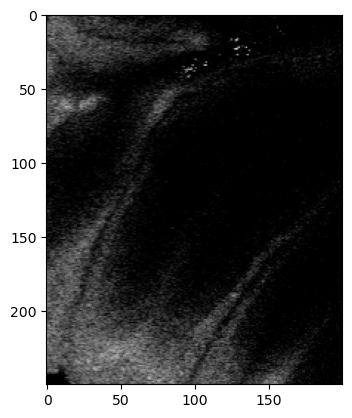

7


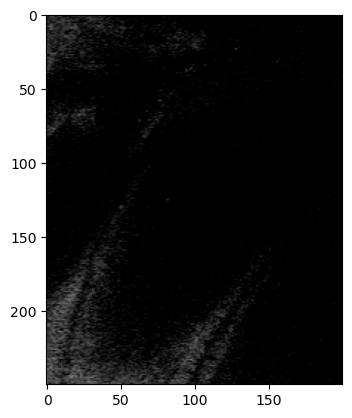

8


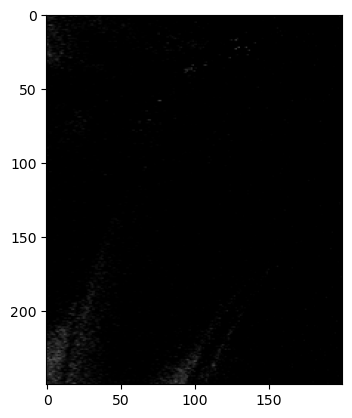

9


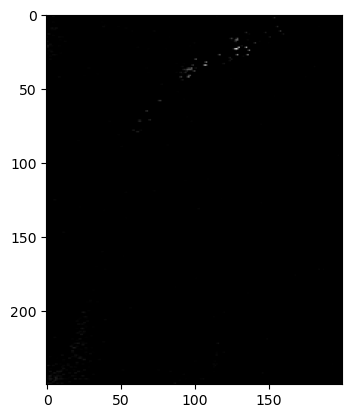

10


IndexError: index 250 is out of bounds for axis 1 with size 236

In [8]:
#Look at slices through sample, adjust numbers to change range and spacing-
for i in range(30):
    print(i)
    layer=resizedoct[:,25*i,:,:]
    plt.imshow(layer[200:450,200:400])
    plt.show()

0


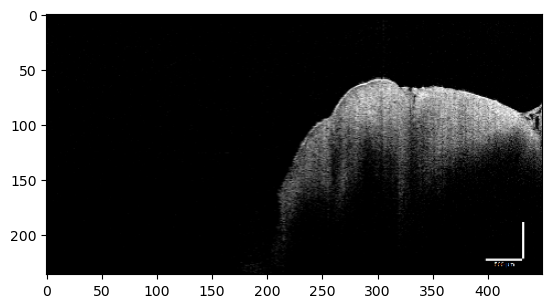

1


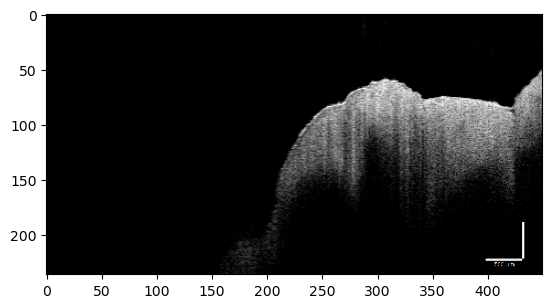

2


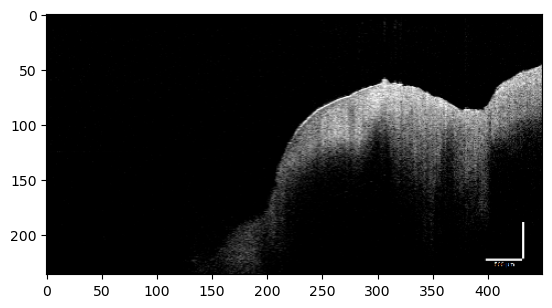

3


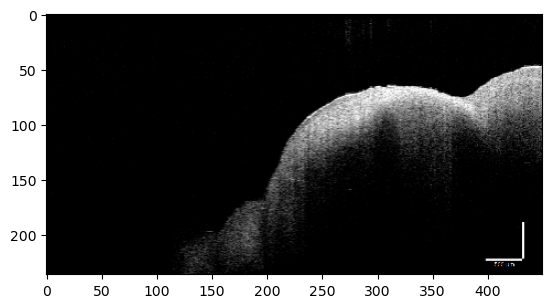

4


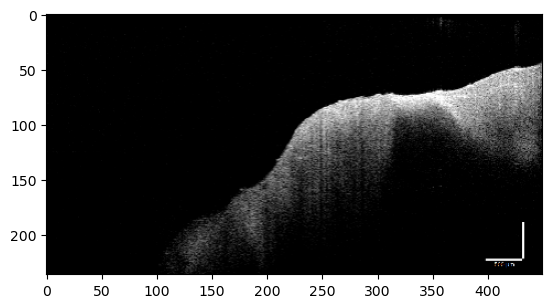

5


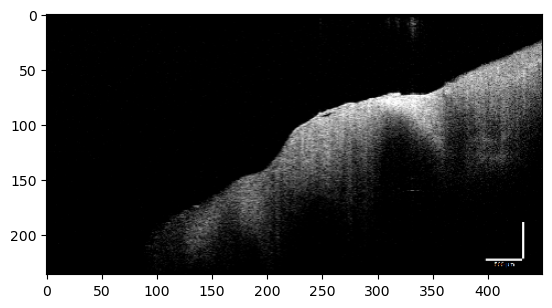

6


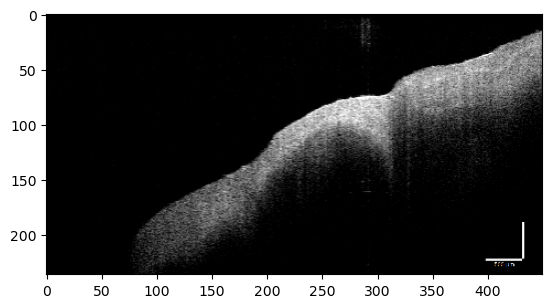

7


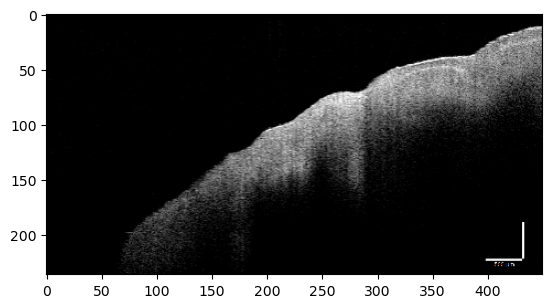

8


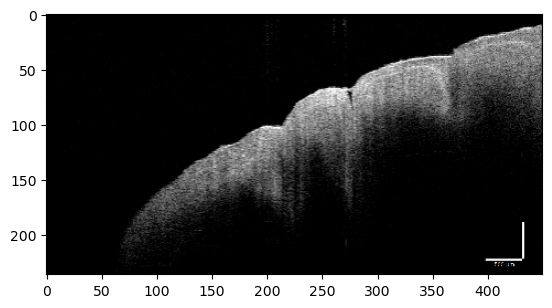

9


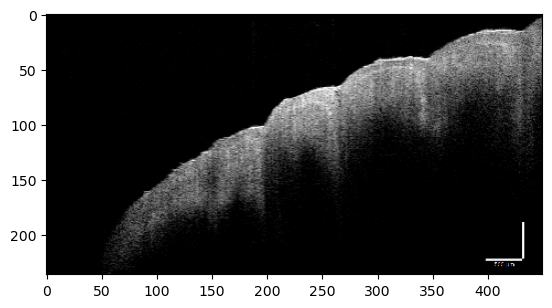

10


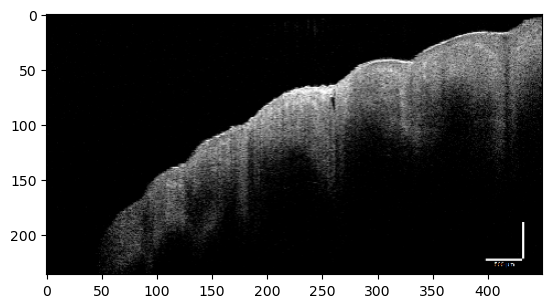

11


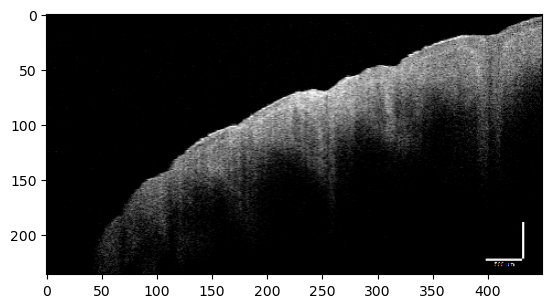

12


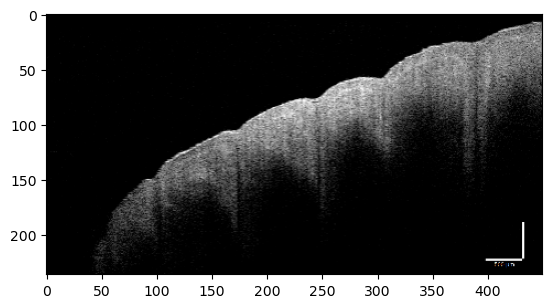

13


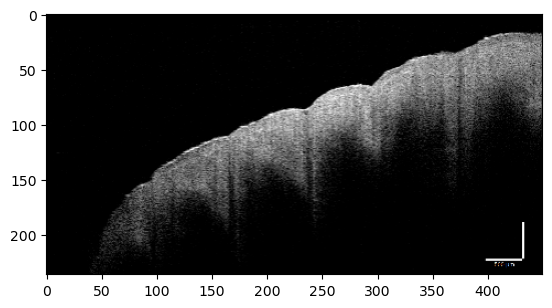

14


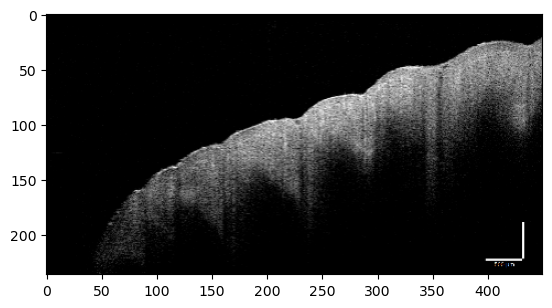

15


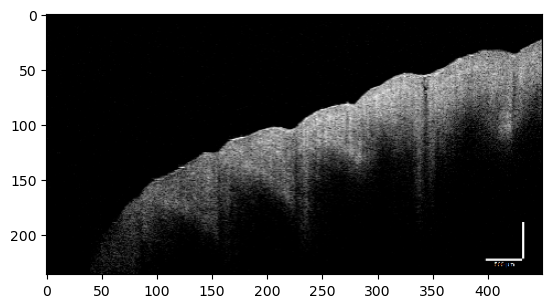

16


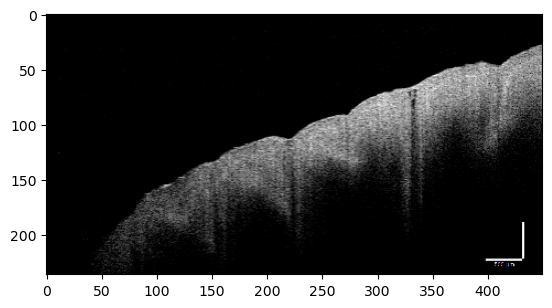

17


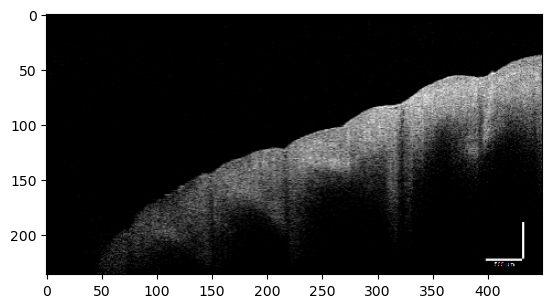

18


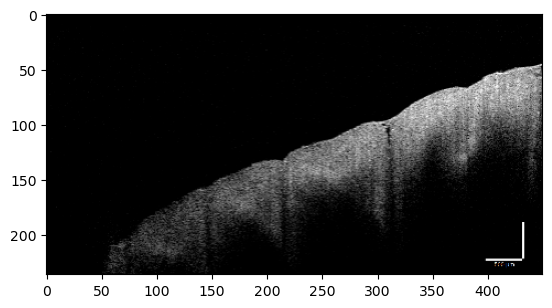

19


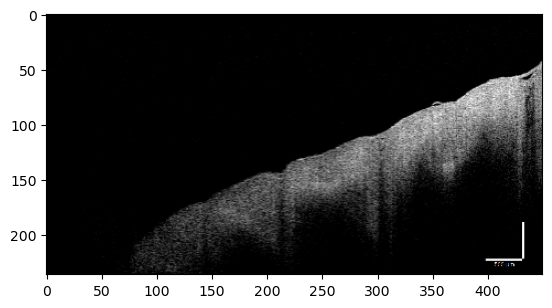

In [9]:
for i in range(20):
    print(i)
    layer2=resizedoct[150+i*15,:750,:,:]
#    layer2=cv2.resize(layer, (747,475), interpolation = cv2.INTER_AREA)
    plt.imshow(layer2)
    plt.show()

0


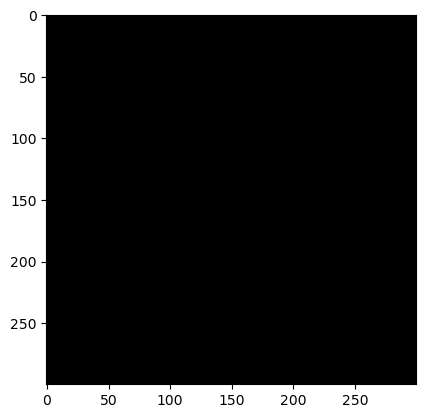

1


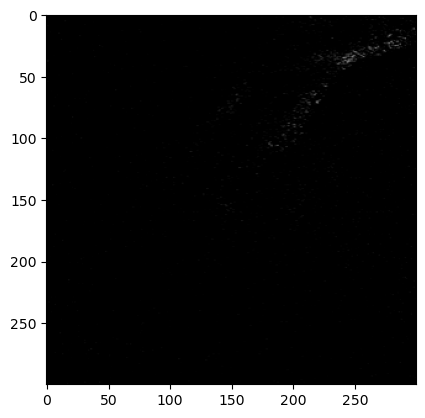

2


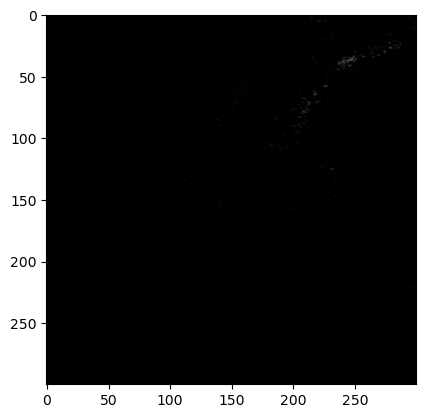

3


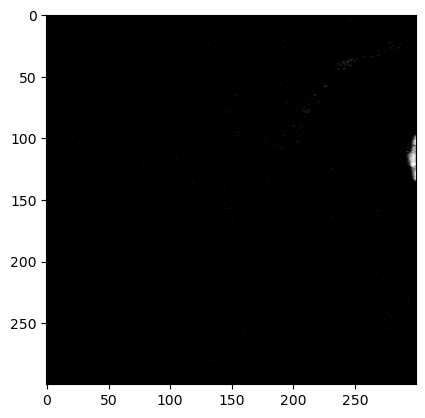

4


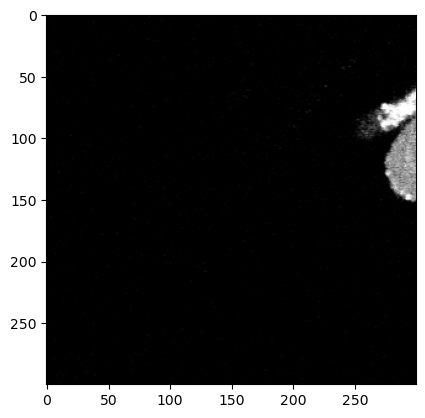

5


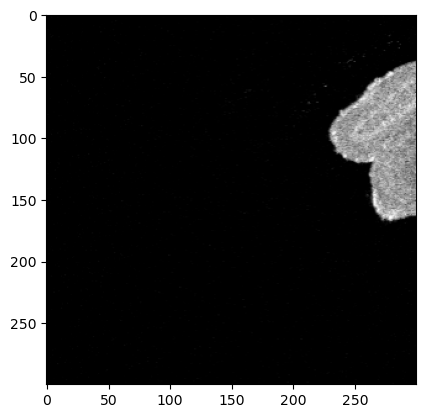

6


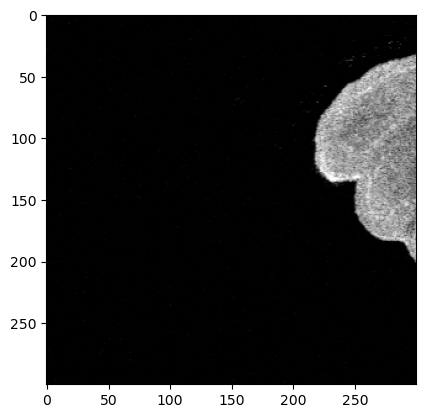

7


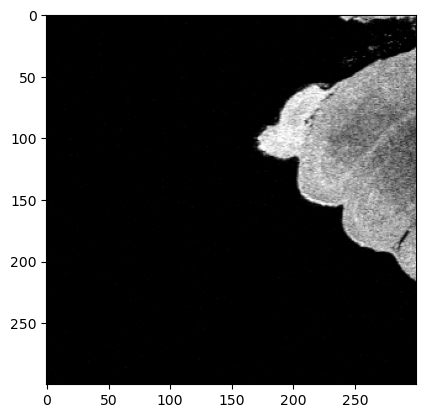

8


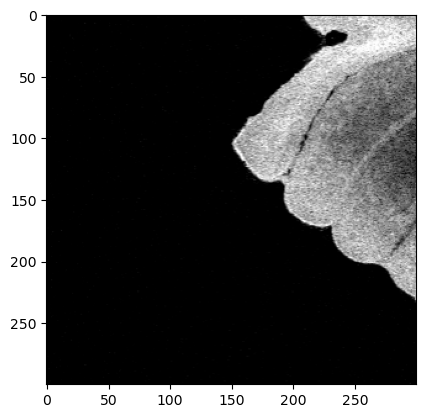

9


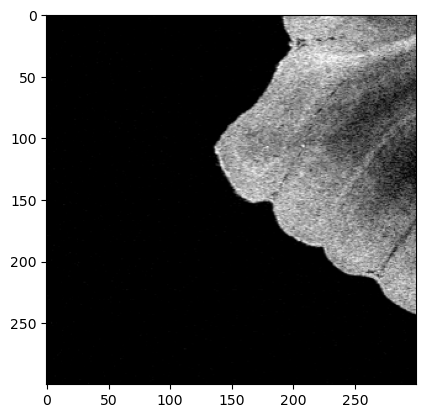

10


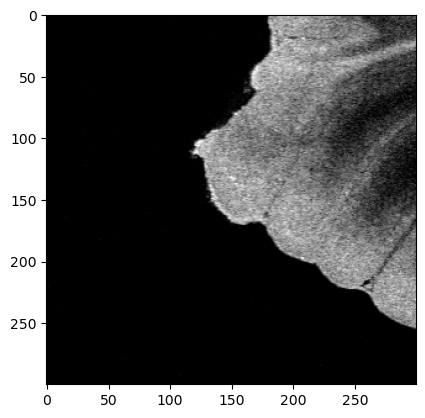

11


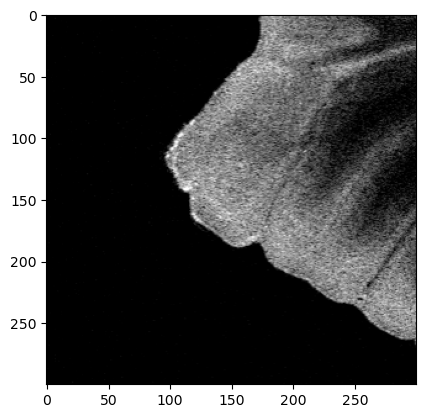

12


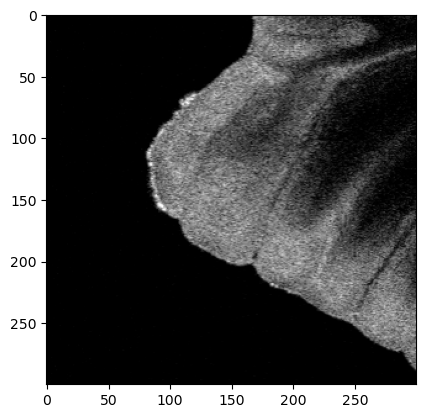

13


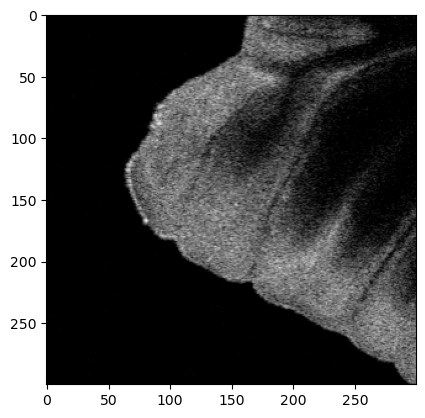

14


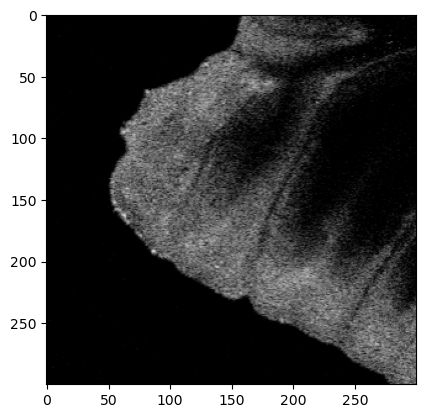

15


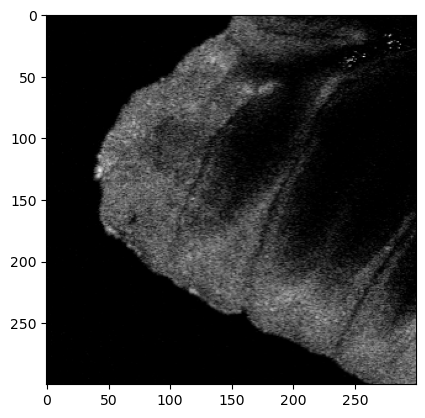

16


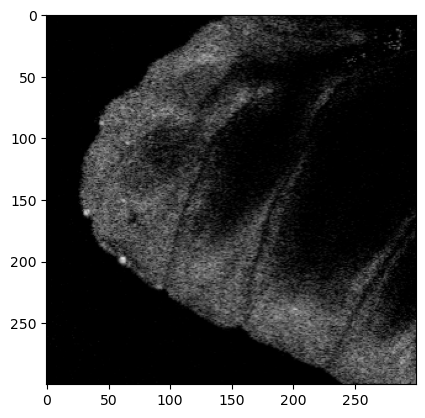

17


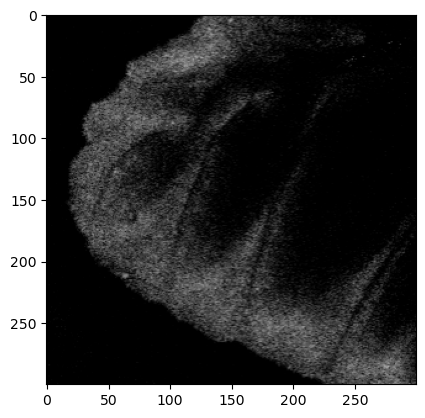

18


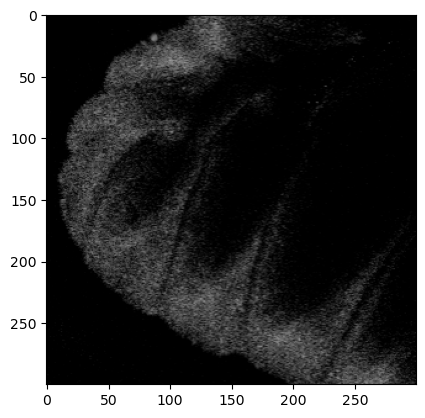

19


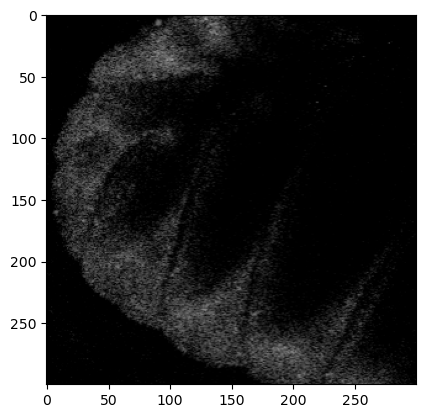

20


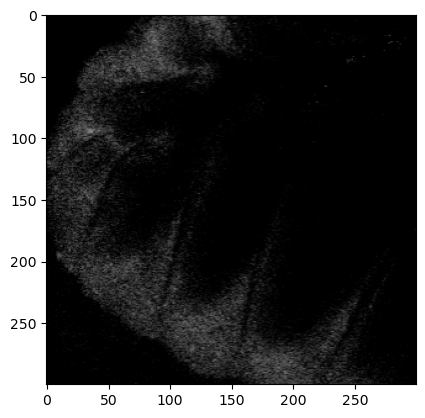

21


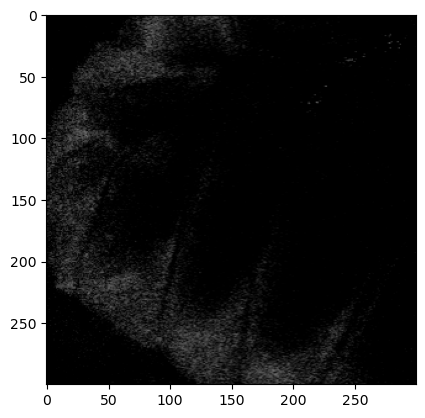

22


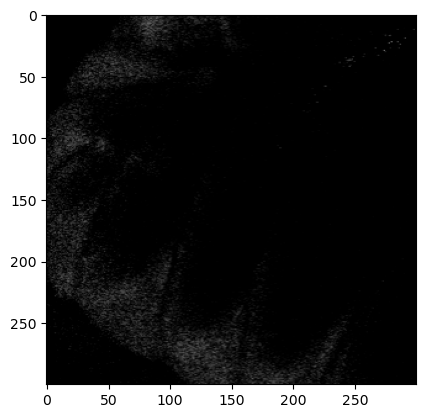

In [8]:
#Take 3d section of OCT to look at:
octchunk=resizedoct[200:500,:,50:350,:]

for i in range(23):
    print(i)
    plt.imshow(octchunk[:,10*i,:,:])
    plt.show()
    

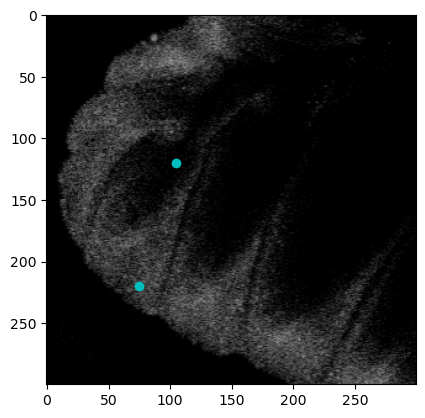

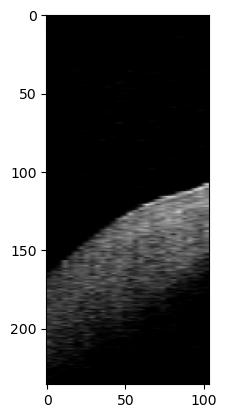

(236, 104, 3)


In [33]:
#Select plane to look at to find curvature-
slice=takeslice(octchunk,75,220,105,120,180)
print(slice.shape)

(236, 104)


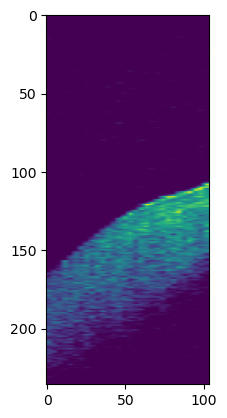

Double clicked at x =  10, y =  160
Double clicked at x =  15, y =  153
Double clicked at x =  21, y =  146
Double clicked at x =  29, y =  141
Double clicked at x =  36, y =  136
Double clicked at x =  43, y =  132
Double clicked at x =  50, y =  126
Double clicked at x =  55, y =  123
Double clicked at x =  63, y =  121
Double clicked at x =  71, y =  116
Double clicked at x =  78, y =  115
Double clicked at x =  85, y =  110
Double clicked at x =  92, y =  109
Double clicked at x =  100, y =  107
Double clicked at x =  64, y =  118
171.90315205528935 0.8222323925299522


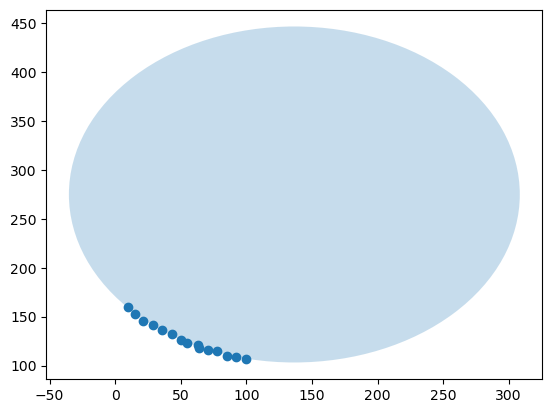

In [38]:
def pressed2(event):
    print('Double clicked at x = % d, y = % d'%(event.x, event.y))
    center_vals.append([event.x,event.y])
    center_xval=event.x
    center_yval=event.y
    canvas.create_oval(center_xval-2, center_yval-2, center_xval+2, center_yval+2, outline="blue",fill="blue",width=4)
    return()

#Fnc to click on a bunch of points along the curve and return rad of curvature for arc
def circle_tracer(slice3d):
    slice=slice3d[:,:,0]
    print(slice.shape)
    slice=(255*slice/np.max(slice)).astype(np.uint8)
    #Put data image in the correct format so it can be used as a reference-
    image1=Image.fromarray(slice)
    plt.imshow(image1)
    plt.show()
  
    width = slice.shape[1] # canvas width
    height = slice.shape[0] # canvas height
    
    global center_vals
    center_vals=[]
    
    center=(int(height/2),int(width/2))

    master = Tk()
    global mask_ref_image
    mask_ref_image =  ImageTk.PhotoImage(image1) 
    # create a tkinter canvas to draw on
    global canvas
    canvas = Canvas(width=width, height=height, bg='white')
    canvas.create_image(center[1],center[0], image = mask_ref_image)
    canvas.pack()
    
    canvas.pack(expand=YES, fill=BOTH)
    #When right click happens choose radius and draw circle
    canvas.bind('<Button-3>', pressed2)
    master.mainloop()
    
    return(center_vals)

vals=np.array(circle_tracer(slice))
#Calculate radius from points-
xc, yc, r, sigma = taubinSVD(vals)

print(r,sigma)

fig, ax = plt.subplots()
ax.scatter(vals[:,0], vals[:,1])
circ=plt.Circle((xc,yc),r, alpha=0.25)
ax.add_patch(circ)
plt.show()